# Deep Learning

**TODO:** Split notebook:
1. backpropagation algorithm
1. batch normalization
1. intor to initializations on DNN 

1. Add discussion a bout gradient vanish on deep learning and how relu can help with that: https://machinelearningmastery.com/how-to-fix-vanishing-gradients-using-the-rectified-linear-activation-function/
    * intro to grad or
    * ds pragamatic tensorflow <== is better lHOw to detect gardient vanish or
    * backpropagation
    

**Goals**:

* Goal understand better the link with gradients and backpropagation
* Review backpropagation
* Implement dense layer and neural netowork
* tets implemenattion
* Learn batch normalization
* IMplement Batch normalization layer


In [87]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf

from typing import List, Set, Dict, Tuple, Optional, Union

%matplotlib inline
np.random.seed(1)

import IPython
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

print(tf.__version__)

2.6.0


## Backpropagation


Maybe this pdf fprm stanford is more reliable 

* https://web.stanford.edu/class/cs224n/readings/gradient-notes.pdf
* https://web.stanford.edu/class/cs224n/slides/cs224n-2020-lecture04-neuralnets.pdf

--------------
* https://kevinzakka.github.io/2016/09/14/batch_normalization/
* https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
* https://medium.com/@a.mirzaei69/implement-a-neural-network-from-scratch-with-python-numpy-backpropagation-e82b70caa9bb



* Understand the math 
Watch this video explaining the math behing backpropagation from stanfor:
* https://www.youtube.com/watch?v=isPiE-DBagM&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6 (Stanford)


Often people confuse back propagation with gradient descent. The gradient descent algorithm minimizes (optmizes) the cost function. And the backpropagation updates all parameters in the neural network based on the chain rule fomula and the gradient returned in the gradient descent algorithm   



### Notes about initializations

**TODO:**
1. Using tensorflow and simple DNN (Peceptron)
    * init parameters as zero
        1. Linear
        1. Relu
        1. sigmoid
        
1. Using tensorflow and simple DNN (keep contant number of neurons to make init simple)
    * init large parameters
    * init small parameters
        * Relu, Linear
        * tanh and sigmoid

Refs:
* He paper: https://arxiv.org/pdf/1502.01852.pdf
* with visual explanation to play: 
    https://www.deeplearning.ai/ai-notes/initialization/#I
* https://wandb.ai/site/articles/the-effects-of-weight-initialization-on-neural-nets <== can help with the code to test all initializations scenarios

1. W = 0, b = 0: DNN not learn, Cost funtion $J = cte$

1. W = cte, b = 0: Is hard to DNN to learn because all neurons has the same contrubution for the output and the grads will be the same so all neuron learn the same thing always. Neuron evolve symetrically hroughout training,ffectively preventing different neurons from learning different things.

1. Case 1: A too-large initialization leads to exploding gradients

Consider deeper DNN with 10 Layers all activation beeing **linear**.

$
W^{[l]} = \begin{bmatrix}
1.5 & 0 \\ 
 0& 1.5
\end{bmatrix} \\
$

for $l = {1,2,...,L}$


$
\hat{y} = W^{[L]}1.5^{L-1}x 
$

The activations $a^{l}$ increase exponentially:
* In backward propagation, this leads to the exploding gradient 
* Cost funct $J$ will oscilate around its minimum !? Why?

1. Case 2: A too-small initialization leads to vanishing gradients 


$
W^{[l]} = \begin{bmatrix}
0.5 & 0 \\ 
 0& 0.5
\end{bmatrix} \\
$

for $l = {1,2,...,L}$

$
\hat{y} = W^{[L]}0.5^{L-1}x 
$

The activations functions decrease exponentially with $l$:

* In backward propagation, this leads to the vanishing gradient
* Leading to convergence of the cost before it has reached the minimum value. Train is slow, pramaeters almost do not change.

In summary it is important to initialize properly the DNN:


```text
* din: dim of the input of the payer
* dout: dim of output of the payer
* d_avg = (d_in + d_out)/2 

|Init  |Activation                           | sigma2 (Normal)|
|------+-------------------------------------+----------------|
|Xavier|Tanh, Linear(None), Logistic, softmax| 1/d_avg        |
|He    |Relu n variants                      | 2/d_avg        |
|leCun |Selu !?                              | 1/d_avg        |
|------+-------------------------------------+----------------|
```

### Implement simple regression first


1. One layer Dense
1. Regression

Steps:
    
* Implement parts 
    1. activatoins
    1. code one layer 


### Forward propagation

<img src="../images/simple_nn.jpg" width="600"/>

$
z^{[l]} = W^{[l]} a^{[l-1]} + b^{[l]} \\
a^{[l]} = g^{[l]}(z^{[l]})
$

<img src="../images/forward_step.png" width="800"/>

### Backward propagation

refs:
* https://sudeepraja.github.io/Neural/ Matrix notation
* https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd
* https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html


<img src="../images/chainrule_example.png" width="400"/>

#### Some notes about the big picture

* We want to optmize the cost function $J(\theta = {W,b}) = \frac{1}{m} \sum^m_{i=1} \ell(\hat{y^{(i)}} = h_{\theta}(x^{(i)}), y^{(i)})$

* In order to do that we need:

    1. We need to update all the parameters: $\{W^{[1]}, b^{[1]},...., W^{[L]}, b^{[L]}\}$ of the NN in the right direction.
    
    1. To discover the right direction to update, we need to compute the gradients.: $\frac{\partial}{\partial W^{[l]}}J$ and $\frac{\partial}{\partial b^{[l]}}J$ for $l = \{1,.., L\} $
    
    1. To compute the gradients, we need to use the chain rule
    

The 4 equations we need to compute the gradients can be written in matrix form as:


$
\delta^L = \frac{\partial}{\partial \hat{y}}J \circ f'(z^{[L]}) \\
\delta^l = \left ( (W^{[l+1]})^t \delta^{[l+1]} \right )  \circ f'(z^{[l]}) \\
\frac{\partial}{\partial W^{[l]}}J = \delta^l (a^{[l-1]})^t  \\
\frac{\partial}{\partial W^{[l]}}J = \delta^l
$
    
where $\hat{y} = a^{[L]}$, $X = a^{[0]}$ and we assume all activations function are the same $f$ . Also, $\circ$ is the element-wise multiplication. It is important in the euqation so the matrix dimensions can match.  

The proof of the equations can be found: http://neuralnetworksanddeeplearning.com/chap2.html#proof_of_the_four_fundamental_equations_(optional)

**TODO**: Try read and understand the proof. It will help you a lot understand the papers in the area. Or if you need to implement you personal layer. 

---------------
* There is a lot of details and math hot to get the equations. But there a ways to develope the equations

    * Using sum and indexes notation like in: $\frac{\partial}{\partial W^{[2]}_{i,j}}J = U_i f'(z^{[3]}_i)a^{[2]}_j \equiv \delta^{[3]}_i a^{[2]}_j$
    
    * Using matrix notation that simplify the equations but it is hard to understand. The equation above is tranlaste as: $\frac{\partial}{\partial W^{[2]}}J = \delta^{[3]}(a^{[2]})^t$ where $\delta^{[3]} = U\circ f'(z^{[3]})$ and $\circ$ is the element-wise or Hadamard product.
    
* UNderstandthe big picture

    * https://medium.com/@a.mirzaei69/implement-a-neural-network-from-scratch-with-python-numpy-backpropagation-e82b70caa9bb  See code in train method <== Help me understand the diff with gradient descent
    * helps to understand the equations: http://neuralnetworksanddeeplearning.com/chap2.html
    * wikipedia: https://en.wikipedia.org/wiki/Backpropagation
    
* UNderstan the implementatiio
    * https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795
    
    
* Understanding math with index notation
    * https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd
    
* Undersatnding math with matrix notation
    * https://sudeepraja.github.io/Neural/
    * https://www.youtube.com/watch?v=isPiE-DBagM&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6 vidoe form standfort
    
    

#### The chain rule and rule while deriving matrix

Chain rules

$
u = u(x(r,t), y(r,y)) \\
\frac{\partial}{\partial r}u = \frac{\partial}{\partial x}u \frac{\partial}{\partial r}x = \frac{\partial}{\partial y}u \frac{\partial}{\partial r}y
$

When deriving related to a matrix or vector

1. The derivative has the same dimension of the the ariable been derived  **

    * Scalar by scalar: $\frac{\partial}{\partial x}f(x) = f'$ , so $f'$ is scalar
    * Scalar by a vector $\frac{\partial}{\partial \mathbf{x}}f(\mathbf{x}) = \mathbf{f'}$ , so $\mathbf{f'}$ is a vector of dim of $\mathbf{x}$
    * Matrix or vector by a matrix: $\frac{\partial}{\partial \mathbf{x}}f(\mathbf{x}) = \mathbf{f'}$ , so $\mathbf{f'}$ is a vector of dim of $\mathbf{x}$

ref: https://kevinzakka.github.io/2016/09/14/batch_normalization/ But I need to double check this rules with other sources and check if it is compatible to 4 Backpropagation equations 

#### Some equations

Try to proof some of the equations

Define gradient in matrix form as:

$
J = J(X_1,X_2,...,X_m)  \\
\frac{\partial}{\partial X}J = [\frac{\partial}{\partial X_1}J, \frac{\partial}{\partial X_2}J, ..., \frac{\partial}{\partial X_m}J] 
$

> PS: derivatives are row vectors


Page 1
<img src="../images/backprop_1.jpg" style="float:left" width="600" align="left"/> 

-----
Page2

<img src="../images/backprop_2.jpg" style="float:left" width="600" align="left"/> 

* The cost or objective function:  

$
J(\theta = {W,b}) = \frac{1}{m} \sum^m_{i=1} \ell(\hat{y^{(i)}} = h_{\theta}(x^{(i)}), y^{(i)})
$

* The loss function:

$
\ell(\hat{y^{(i)}}, y^{(i)})
$

* The activation function of the last layer:

$
g = h_{\theta}(x^{(i)})
$

Reviewing chaing rule:

* For function of 1 variable:
$
y =  f(u(x)) \\
\frac{d}{dx}y = \frac{d}{du}y \frac{d}{dx}u
$

* For 2 vriables 

$
y =  f(u(x)) \\
\frac{d}{dx}y = \frac{d}{du}y \frac{d}{dx}u
$

To optmize the cost funtction $J(W^{[1]},b^{[1]},..., W^{[l]}, b^{[l]}, ...,W^{[L]}, b^{[L]} )$, where $L$ is the number of layers, we need to compute:


$
\frac{\partial}{\partial W^{[l]}}J = \frac{\partial}{\partial z^{[l]}}J \frac{\partial}{\partial W^{[l]}}z^{[l]} \\ 
\frac{\partial}{\partial W^{[l]}}J = \frac{\partial}{\partial z^{[l]}}J a^{[l-1]} \\
\frac{\partial}{\partial b^{[l]}}J = \frac{\partial}{\partial z^{[l]}}J \frac{\partial}{\partial b^{[l]}}z^{[l]} \\ 
\frac{\partial}{\partial b^{[l]}}J = \frac{\partial}{\partial z^{[l]}}J
$


The common term is called the local gradient:

$
\delta^{[l]} = \frac{\partial}{\partial z^{[l]}}J
$


-----------------


* Forwards pass in matrix notation:

https://sudeepraja.github.io/Neural/ Matrix notation

$
J(\theta = {W,b}) = \frac{1}{m} \sum^m_{i=1} \ell(\hat{y^{(i)}} = h_{\theta}(x^{(i)}), y^{(i)}) \\
a^{[l]} = g^{[l]}(z^{[l]} = W^{[l]}a^{[l-1]} + b^{[l]})
$

* Backwards pass

Last layer (mse loss)

$
\delta^{[L]} = (a^{[L]} - y) g'^{[L]}(z^{[L]}) \\
\delta^{[L]} = (a^{[L]} - y) g'^{[L]}(W^{[L]}a^{[L-1]}) \\  
$

Hidden Layers

$
\delta^{[l]} = (W^{[l]})^t \delta^{[l+1]} g'^{[l]}(W^{[l]}a^{[l-1]} + b^{[l]})  
$

Weight updates:


$
\frac{\partial}{\partial W^{[l]}}J  = \delta^{[l]} (a^{[l]})^t \\
W^{[l]} = W^{[l]} - \alpha \frac{\partial}{\partial W^{[l]}}J \\
\frac{\partial}{\partial b^{[l]}}J  = \delta^{[l]} \\
b^{[l]} = b^{[l]} - \alpha \frac{\partial}{\partial b^{[l]}}J
$

#### Double checking the backpropagation equations

https://medium.com/@a.mirzaei69/implement-a-neural-network-from-scratch-with-python-numpy-backpropagation-e82b70caa9bb


Page 1
<img src="../images/backprop_notes_0.jpg" style="float:left" width="600" align="left"/> 

-----
Page 2

<img src="../images/backprop_notes_1.jpg" style="float:left" width="600" align="left"/> 

-------
Page 3
<img src="../images/backprop_notes_2.jpg" style="float:left" width="600" align="left"/> 

------
Page 4
<img src="../images/backprop_notes_3.jpg" style="float:left" width="600" align="left"/> 

------
Page 5
<img src="../images/backprop_notes_4.jpg" style="float:left" width="600" align="left"/> 

### Implementation

In [9]:
# WIP: Still need to finish this code
class Layer():
    
    def _get_activation_func(self,activation_type):
            
        if activation_type == 'relu':
            
            def activation_func(z: np.array):
    
                a = np.maximum(0.0,z)
        
                return a
            
            def activation_derivative(z: np.array):
                
                return 
        
        else:
            
            def activation_func(z: np.array):
    
                a = 1.0/(1.0 + np.exp(-z))
        
                return a
        
            def activation_derivative_func(z: np.array):
                
                return activation_func*(1.0 - activation_func)
                
        
        return activation_func, activation_derivative_func

    def __init__(self, input_size, output_size, activation_type):

        self.activation_type = activation_type
        
        self.input_size = input_size
        self.output_size = output_size
        
        
        activation , first_deriv_of_activation = self._get_activation_func(activation_type)
        
        self.activation = activation
        self.activation_derivative = first_deriv_of_activation
            
class DenseLayer(Layer):
    
    def __init__(self, input_size, output_size, activation_type):
        
        super().__init__( input_size, output_size, activation_type)

    def forward_propagation(self, X_in: np.array, W: np.array, b: np.array) -> Tuple[np.array]:
        
        z = W.dot(X_in)
        a = self.activation(z)
        
        return a, z
    
    def backward_propagation(self, da, W, b, z, a_prev):

        dz = self.activation_derivative(z)*da  # element-wise multiplication
        
        dW = np.dot(dz, a_prev.T) / m
        db = np.sum(dz, axis=1, keepdims=True) / m
        
        da_prev = np.dot(W.T, dZ)

        return da_prev, dW, db

In [8]:
in_size = 1
out_size = 1
batch_size = 3

l1 = DenseLayer(in_size,out_size,'relu')
l1.activation_type

l2 = DenseLayer(in_size,out_size, 'sigmoid')
l2.activation_type


X = np.array([[1.0, 2.0], 
              [1.0,4.0],
             [0.0, 0.0]])

print(f"batch_size: {X.shape[0]}; in_size: {X.shape[1]}")

W = np.array([-1.0, 0.5]).reshape((1,2))
W.shape
print(f"out_size: {W.shape[0]}; in_size: {W.shape[1]}")

b = np.zeros((1,))

print("Expected Z")
W.dot(X[0,:])
W.dot(X[1,:])
W.dot(X[2,:])

print("Layers output")

for k in range(batch_size):
    
    Xb = X[k,:]

    l1.forward_propagation(Xb,W,b)
    l2.forward_propagation(Xb,W,b)

UnboundLocalError: local variable 'activation_derivative_func' referenced before assignment

In [17]:
class NN():

    def __init__(self, layers, learning_rate = 0.1, seed= 2021):
        
        self._seed = seed 
        np.random.seed(seed)

        self.layers = layers
        self.n_layers = len(layers)
        self.params_values = {}

        self._init_layer_parameter_random()
        
        loss, loss_derivative = self._get_loss('cross-entropy')
        
        self.loss = loss
        self.loss_derivative = loss_derivative
        
        self.lr = learning_rate
        

    def _get_loss(loss_type):
        
        if loss_type == 'cross-entropy':
            
            def loss(y_hat, y):
                
                # J = - 1/m \sum_1^m y log y_hat - (1 - y) log(1-y_hat)  <= cross entropy loss 
                m = y_hat.shape[1]
                cost = -1.0 / m * (np.dot(y, np.log(y_hat).T) + np.dot(1.0 - y, np.log(1.0 - y_hat).T))
                
            return np.squeeze(cost)
        
        
            def loss_derivative(y_hat, y):
                
                m = y_hat.shape[1]
                
                # y_hat is teh activation in the last Layer L: a^{[L]}
                # dJ/da^[L] = dJ/dy_hat = y/y_hat - (1-y)/(1-y_hat)
                da_prev =  -(np.divide(y, y_hat) - np.divide(1 - y, 1 - y_hat))/m
            
                return da_prev
        else:
            
            # mse loss
           
            def loss(y_hat, y):
                
                # J = - 1/m \sum_1^m y log y_hat - (1 - y) log(1-y_hat)  <= cross entropy loss 
                m = y_hat.shape[1]
                cost = -0.5/m * np.dot((y - y_hat).t, (y - y_hat))
                
            return np.squeeze(cost)
        
        
            def loss_derivative(y_hat, y):

                m = y_hat.shape[1]
                
                # y_hat is teh activation in the last Layer L: a^{[L]}
                # TODO: Review this equation. Maybe the constant is missing
                # Should I include or not the term f'(z) the activation function
                da_prev =  1.0/m * (y-y_hat)
            
                return da_prev
            

        return loss, loss_derivative
        
    # All bias are zero
    def _init_layer_parameter_random(self):
        
        for idx, layer in enumerate(self.layers):
            
            layer_idx = idx + 1
            
            # We need initialize with small values. Because high values are regions with
            # samall (almost vanish) gradients for sigmois, tanh funcitons
            W = np.random.randn(layer.output_size, layer.input_size) * 0.01
            self.params_values['W' + str(layer_idx)] =  W
            
            b = np.random.randn(layer.output_size, 1) * 0.01
            self.params_values['b' + str(layer_idx)] = b

    def _init_layer_paremeter_xavier(self):
        
        pass
        
        
    def compile(self, optimizer,loss_type,metrcis):
        
        # TODO: Set this objects in the neral networks
        pass
        
    def accuracy(self, y_hat, y):
        
        y_hat_ = convert_prob_into_class(y_hat)
        
        return (y_hat_ == y).all(axis=0).mean()

        
    def predict(self, X_in: np.array) -> np.array:
        
        y, _ = self.forward_propagation(X_in)
        
        return y
     
    def forward_propagation(self, X_in: np.array) -> Tuple[np.array, dict] : 
        # forward propagation
        
        memory = {}
        # a^{[0]} = X_in. The first activation are the inputs
        a_curr = X_in
        
        for idx, layer in enumerate(self.layers):
            
            layer_idx = idx + 1
            a_prev = A_curr
            
            W_curr = self.params_values["W" + str(layer_idx)]
            b_curr = self.params_values["b" + str(layer_idx)]
            
            a_curr, z_curr = layer.forward_propagation(a_curr, W_curr, b_curr) 
            
            # Need this for back propagation 
            memory["a" + str(idx)] = a_prev  # a^{[0]} = X_in
            memory["z" + str(layer_idx)] = z_curr
    
        return A_curr, memory
    
    def backward_propagation(y_hat, y, memory):
        
        gradients = {}
        m = y.shape[1]
        y = y.reshape(y_hat.shape)
        
        # d/da^{[L]}J 
        da_prev = self.loss_derivative(y_hat, y)
        
        for idx, layer in reversed(list(enumerate(layers))):
    
            layer_idx = idx + 1
            print(f"{idx}: {layer}")
            
            da_curr = da_prev

            a_prev = memory["a" + str(layer_idx - 1)]
            z = memory["z" + str(layer_idx)]
            
            W = self.params_values["W" + str(layer_idx)]
            b = self.params_values["b" + str(layer_idx)]
            
            da_prev, dW, db = layer.backward_propagation(da, W, b, z, a_prev)
            
            gradients["dW" + str(layer_idx_curr)] = dW
            gradients["db" + str(layer_idx_curr)] = db
            
        return gradients
    
    def _update_parameters(self,grads_values):
        
        for idx, layer in enumerate(self.layers):
            
            layer_idx = idx + 1
            
            self.params_values["W" + str(layer_idx)] -= self.lr * grads_values["dW" + str(layer_idx)]        
            self.params_values["b" + str(layer_idx)] -= self.lr * grads_values["db" + str(layer_idx)]

    
    def train(self, X, y, epochs=3):
        
        cost_history = []
        accuracy_history = []
        
        # Gradient descent 
        for e in range(epochs):
         
            y_hat, memory = forward_propagation(X_in)
            
            cost = self.loss(y_hat, y)
            acc = self.accuracy(y_hat, y)
            
            cost_history.append(cost)
            accuracy_history.append(acc)
           
            #  da_prev, dW, db = grads
            grads = self.backward_propagation(y_hat, y, memory)
           
            # update self.params_values
            self._update(grads)
            
        return self.params_values, cost_history, accuracy_history
        

**TODO**:
 
1. ~~validate forward~~ OK
1. validate accuracy  this is easy
1. validate loss function  easy
1. validate layer backpropagation   this one is hard todo it
1. validate update parameters This one is easy
    

In [13]:
layers = [1,2,3]


for idx, layer in enumerate(list(reversed(layers))):
    
    print(f"{idx}: {layer}")
    
print()
for idx, layer in reversed(list(enumerate(layers))):
    
    idx = idx + 1
    
    print(f"{idx}: {layer}")

0: 3
1: 2
2: 1

3: 3
2: 2
1: 1


In [ ]:
# Code to compare or study.
# The loss is mean square erro (mse = (y - y_hat)^2)
def backpropagation(self,y, z_s, a_s):
    
    dw = []  # dC/dW
    db = []  # dC/dB
    
    deltas = [None] * len(self.weights)  # delta = dC/dZ  known as error for each layer
    
    # insert the last layer error
    # the derivative of mse: 2(y-y_hat)
    deltas[-1] = ((y-a_s[-1])*(self.getDerivitiveActivationFunction(self.activations[-1]))(z_s[-1]))

    # Perform BackPropagation
    for i in reversed(range(len(deltas)-1)):
    
        deltas[i] = self.weights[i+1].T.dot(deltas[i+1])*(self.getDerivitiveActivationFunction(self.activations[i])(z_s[i]))        
        batch_size = y.shape[1]
        db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for d in deltas]
        dw = [d.dot(a_s[i].T)/float(batch_size) for i,d in enumerate(deltas)]
        
        # return the derivitives respect to weight matrix and biases
    return dw, db


tetsing parameter init with previous layers



In [5]:
l1 = DenseLayer(input_size=2,output_size=1,activation_type = 'relu')
l2 = DenseLayer(input_size=1,output_size=1,activation_type = 'sigmoid')

layers = [l1,l2]

nn = NN(layers)
nn.params_values

y , memory = nn.predict(X[1,:])
y 
memory

{'W1': array([[0.01488609, 0.00676011]]),
 'b1': array([[-0.00418451]]),
 'W2': array([[-0.00806521]]),
 'b2': array([[0.00555876]])}

array([0.49991546])

{'A0': array([1., 4.]),
 'Z1': array([0.04192653]),
 'A1': array([0.04192653]),
 'Z2': array([-0.00033815])}

## Batch normalization  


**TODO**

* Read the paper. It explain the motivations, why there is trainable parameters and how the backpropagation is affected. There isn important conclusion regards the mistake of not including the dependency of x when doing back proagation of the bias parameter taht clears depend of the mean of the mini batch

(Breaktrough in the area)
refs:
* https://towardsdatascience.com/understanding-batch-normalization-with-examples-in-numpy-and-tensorflow-with-interactive-code-7f59bb126642 <= very good in simple.
* https://kevinzakka.github.io/2016/09/14/batch_normalization/
* Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift (paper)
    * Authors: Sergey Ioffe (same author of PLDA and works at Google) n Christian Szegedy (google)
    * https://arxiv.org/pdf/1502.03167.pdf Paper **TODO** Read the paper. It is simple and easy to understand/ It is a good gain experience in reading paper  
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization tensprflow doc


refs:
* https://www.deeplearningbook.org/contents/optimization.html
* https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
* https://arxiv.org/pdf/1502.03167.pdf
* https://arxiv.org/pdf/1702.03275.pdf
* https://www.youtube.com/watch?v=nUUqwaxLnWs
* https://arxiv.org/pdf/1805.11604.pdf
* https://towardsdatascience.com/understanding-batch-normalization-with-examples-in-numpy-and-tensorflow-with-interactive-code-7f59bb126642 <= very good in simple.
* https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795    
* https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/
* https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739  <== good visual explanation (reduce gradients jiggling)

* Batch normalization backpropagation
    * https://kevinzakka.github.io/2016/09/14/batch_normalization/  with the equations
    * https://arxiv.org/pdf/1502.03167.pdf  the paper is look like more clear


Pros:
* Batch Normalization is also a regularization technique. Not strong as dropout or l1 n l2
* Train fast (you need less epochs)
    * numerical stability. The models become less sensible to large learning rates. You can use much large learning rates and converge fast

Eq from the original paper: https://arxiv.org/pdf/1502.03167.pdf


$
BN(Wx) = BN((aW)x) \\
\frac{\partial}{\partial x} BN((aW)x) \equiv  \frac{\partial}{\partial x} BN(Wx) \\
\frac{\partial}{\partial (aW)} BN((aW)x) \equiv \frac{1}{a} \frac{\partial}{\partial W} BN(Wx)
$

    * minimizes jiggling because of reduce internal covarian shift (keep learnig rate constant, it still training fast because reduce jiggling while comparing with and without BN)
    
* DO not need dropout. You cannot use together
* Good for deeper networks like **CNN** and **RNN** (Normally you need a large number of layers )
* Minimize Gradient Vanish problems: 
    * helps to keep z = WX + b between [-4,4] where the gradients is not vanished for sigmoids functions. same for relu and tanh
    * For this to be effective, us **BatchNorm layer before the activation of the layer**
    * https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484
    * "We add the BN transform immediately before the
nonlinearity, by normalizing" page 5, from the paper https://arxiv.org/pdf/1502.03167.pdf

Crons:
* Useless in SGD. Only use wih Gradiwnt Descent or mini-batch. Because is the mean and std of the mini-batch and SGD has batch size = 1



**It is being asked more often in the job interview**

Batch normalization is the technique to improve the performance and stability of neural networks by normalizing the inputs in every layer so that they have mean output activation of zero and standard deviation of one.

**Don’t Use With Dropout:**

Batch normalization offers some regularization effect, reducing generalization error, perhaps no longer requiring the use of dropout for regularization.


* Input are the values of x over a batch: $B = {x_1, x_2,..., x_i,..., x_m}$
    * where $m$ is the batch size
* Output: $y_i = BN_{\gamma,\beta}(x_i)$
* Learning parameters: $\gamma$ and $\beta$
* Normalization:

$
\mu_B = \frac{1}{m} \sum_{i=1}^m x_i \\
\sigma_B^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2 \\
z_i = \frac{x_i - \mu_B}{\sqrt{\sigma^2_B + \epsilon}} \\
y_i = BN_{\gamma,\beta}(x_i) \equiv \gamma z_i + \beta  \text{ <= scale and shift} 
$


Matrix formulation

$
\mu_B = \frac{1}{m}xˆt \mathbb{1} \\
v = \frac{1}{m} (x-\mu_B)ˆt(x-\mu_B) \\
z = (x-\mu_B)\sqrt{(v + \epsilon)^{-1}} \\
y = \gamma z + \beta 
$


For gradients equatiosn:
    
* https://www.adityaagrawal.net/blog/deep_learning/bprop_batch_norm
* https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html  <== not sure the inverse is right need to test
* https://chrisyeh96.github.io/2017/08/28/deriving-batchnorm-backprop.html <== complica demais mas da para usar para conferir, **MAS USA AS MESMAS EQ que EU na forma matricial**
* https://kevinzakka.github.io/2016/09/14/batch_normalization/
* papers teher is the eq: https://arxiv.org/pdf/1502.03167.pdf
    

In [113]:
x = np.array([[1,2],[2,2],[0,5]])
x.shape
x.T

_ones = np.ones((3,1))

print("mean matrix")
mu = np.matmul(x.T,_ones)/3.0
mu.shape
mu

print("variance matrix")
# v is diagonal and epsilon is diagonal as well
# the inverse of this matrix is the inverse of the non zero elements
v = np.matmul((x- mu.T).T,(x - mu.T))/3.0
v


# comparing with np variance and covariance matrix
print("conparing ith numpy var and covar ")
np.var(x, axis=0)
np.cov(x)
np.cov(x.T)


print("Inversion of v")
# np.linalg.inv(v)
v_inv = v
v_inv[0,0] = 3.0/2.0
v_inv

v_inv = np.linalg.inv(v)

np.matmul(v,v_inv)

# z 
# z = np.matmul((x-mu).T,(np.sqrt()))
# z


(3, 2)

array([[1, 2, 0],
       [2, 2, 5]])

mean matrix


(2, 1)

array([[1.],
       [3.]])

variance matrix


array([[ 0.66666667, -1.        ],
       [-1.        ,  2.        ]])

conparing ith numpy var and covar 


array([0.66666667, 2.        ])

array([[ 0.5,  0. ,  2.5],
       [ 0. ,  0. ,  0. ],
       [ 2.5,  0. , 12.5]])

array([[ 1. , -1.5],
       [-1.5,  3. ]])

Inversion of v


array([[ 1.5, -1. ],
       [-1. ,  2. ]])

array([[ 1.00000000e+00, -1.11022302e-16],
       [-2.22044605e-16,  1.00000000e+00]])

To find an expression for the gradients of Batch normalization we need to remember that:
    
$
y = BN_{\gamma,\beta}(x) \equiv y(\gamma,\beta,\mu_B, \sigma^2_B(\mu_B)) =  y(\gamma,\beta,\mu_B) \\ 
\sigma^2_B  \equiv\sigma^2_B(\mu_B) = \frac{1}{m} (x - \mu_B)^t(x - \mu_B) \\
z = z(\mu_B) \equiv \frac{x - \mu_B}{\sqrt{\sigma^2_B + \epsilon}} \\
$
    
You can write $\mu_B$ in matrix formulation as:

$
\mu_B = \frac{1}{m}xˆt \mathbb{1}_{1,d}
$

In [21]:
# Batch
X = np.random.uniform(0,5.0,size=(10))
X

print(f"shape: {X.shape}; mean: {X.mean():.2f}; std: {X.std():.2f}")


array([2.87152147, 1.85580424, 2.26072622, 1.00925124, 2.84652559,
       0.97547987, 2.91852008, 2.38156737, 2.589072  , 4.11549317])

shape: (10,); mean: 2.38; std: 0.89


In [22]:
gamma = 1.0
beta = 0.0
epsilon = 0.0

# because we did not train the layer, we are passing the mean and the variance of the batch
Y = tf.nn.batch_normalization(X,
                    mean = X.mean(axis=0),        # batch mean
                    variance = X.var(axis=0),     # batch var
                    offset = beta,scale = gamma,  # batch beta and gamma See equations  
                    variance_epsilon = epsilon)   # batch epsilon See equations

Y.numpy()

# comparing with numpy

Z = (X - X.mean(axis=0))/np.sqrt(X.var(axis=0) + epsilon)
Y = gamma * Z + beta
Y

# Expectd zero mean and unit variance
print(f"shape: {Y.shape}; mean: {Y.mean():.2f}; std: {Y.std():.2f}")

array([ 5.48732024e-01, -5.90764377e-01, -1.36497064e-01, -1.54048155e+00,
        5.20690049e-01, -1.57836842e+00,  6.01458063e-01, -9.29752983e-04,
        2.31862185e-01,  1.94429885e+00])

array([ 5.48732024e-01, -5.90764377e-01, -1.36497064e-01, -1.54048155e+00,
        5.20690049e-01, -1.57836842e+00,  6.01458063e-01, -9.29752983e-04,
        2.31862185e-01,  1.94429885e+00])

shape: (10,); mean: 0.00; std: 1.00


### Ex: Model with Batch vs without batch noraliztion

ref: https://analyticsindiamag.com/hands-on-guide-to-implement-batch-normalization-in-deep-learning-models/

In [36]:
from keras.datasets import mnist

(input_train, target_train), (input_test, target_test) = mnist.load_data()

* Data preaparation

In [37]:
# Shape of the input sets
input_train_shape = input_train.shape
input_test_shape = input_test.shape 

input_train_shape
input_test_shape

# Normalize input data
input_train = input_train / 255
input_test = input_test / 255

(60000, 28, 28)

(10000, 28, 28)

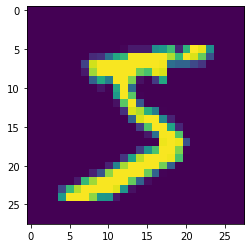

In [39]:
img = input_train[0,:,:]
imshow(np.asarray(img))

In [40]:
# Keras layer input shape
input_shape = (input_train_shape[1], input_train_shape[2], 1)

input_shape

# Reshape the training data to include channels
input_train = input_train.reshape(input_train_shape[0], input_train_shape[1], input_train_shape[2], 1)

input_test = input_test.reshape(input_test_shape[0], input_test_shape[1], input_test_shape[2], 1)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

input_train.min()
input_train.mean()
input_train.max()

(28, 28, 1)

0.0

0.13066062

1.0

In [41]:
# Model configuration
batch_size = 250
no_epochs = 10
no_classes = 10
validation_split = 0.2
verbosity = 1

In [42]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))


model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               409856    
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

In [43]:
# Compile the model
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

print(f"default lr: {tf.keras.backend.get_value(model.optimizer.lr)}")

# Fit data to model
history = model.fit(input_train, target_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)

# Generate generalization metric  s
score = model.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Epoch 1/10
192/192 [==============================] - 31s 161ms/step - loss: 0.2906 - accuracy: 0.9176 - val_loss: 0.0886 - val_accuracy: 0.9734
Epoch 2/10
192/192 [==============================] - 32s 167ms/step - loss: 0.0681 - accuracy: 0.9789 - val_loss: 0.0611 - val_accuracy: 0.9812
Epoch 3/10
192/192 [==============================] - 31s 159ms/step - loss: 0.0488 - accuracy: 0.9851 - val_loss: 0.0452 - val_accuracy: 0.9869
Epoch 4/10
192/192 [==============================] - 30s 157ms/step - loss: 0.0356 - accuracy: 0.9895 - val_loss: 0.0425 - val_accuracy: 0.9875
Epoch 5/10
192/192 [==============================] - 30s 159ms/step - loss: 0.0282 - accuracy: 0.9912 - val_loss: 0.0474 - val_accuracy: 0.9869
Epoch 6/10
192/192 [==============================] - 28s 148ms/step - loss: 0.0231 - accuracy: 0.9929 - val_loss: 0.0386 - val_accuracy: 0.9887
Epoch 7/10
192/192 [==============================] - 28s 146ms/step - loss: 0.0178 - accuracy: 0.9945 - val_loss: 0.0368 - val_ac

In [120]:
model_batch = tf.keras.Sequential()

# add layer and batch normalizations layers
model_batch.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_batch.add(tf.keras.layers.BatchNormalization())
model_batch.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_batch.add(tf.keras.layers.BatchNormalization())
model_batch.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_batch.add(tf.keras.layers.BatchNormalization())
model_batch.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model_batch.add(tf.keras.layers.BatchNormalization())
model_batch.add(tf.keras.layers.Flatten())
model_batch.add(tf.keras.layers.Dense(256, activation='relu'))
model_batch.add(tf.keras.layers.BatchNormalization())
model_batch.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

model_batch.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 64)        

In [121]:
# Compile the model
model_batch.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=0.01),
              metrics=['accuracy'])

print(f"default lr: {tf.keras.backend.get_value(model_batch.optimizer.lr)}")

# Fit data to model
history_batch = model_batch.fit(input_train, target_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)

# Generate generalization metric  s
score = model_batch.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

default lr: 0.009999999776482582
Epoch 1/10
192/192 [==============================] - 55s 280ms/step - loss: 0.1119 - accuracy: 0.9657 - val_loss: 5.0127 - val_accuracy: 0.1088
Epoch 2/10
192/192 [==============================] - 54s 283ms/step - loss: 0.0406 - accuracy: 0.9871 - val_loss: 1.0008 - val_accuracy: 0.7089
Epoch 3/10
192/192 [==============================] - 55s 286ms/step - loss: 0.0266 - accuracy: 0.9915 - val_loss: 0.0548 - val_accuracy: 0.9847
Epoch 4/10
192/192 [==============================] - 48s 250ms/step - loss: 0.0230 - accuracy: 0.9925 - val_loss: 0.1054 - val_accuracy: 0.9737
Epoch 5/10
192/192 [==============================] - 50s 261ms/step - loss: 0.0189 - accuracy: 0.9936 - val_loss: 0.0968 - val_accuracy: 0.9781
Epoch 6/10
192/192 [==============================] - 50s 260ms/step - loss: 0.0146 - accuracy: 0.9949 - val_loss: 0.0630 - val_accuracy: 0.9857
Epoch 7/10
192/192 [==============================] - 44s 231ms/step - loss: 0.0148 - accuracy: 0

Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

(0.9, 1.01)

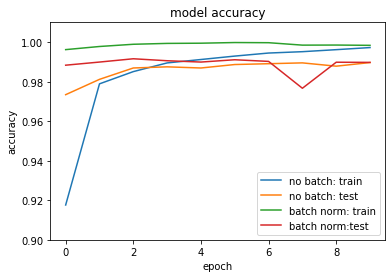

In [119]:
# Show dont tell me

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_batch.history['accuracy'])
plt.plot(history_batch.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['no batch: train', 'no batch: test','batch norm: train', 'batch norm:test'], loc='lower right')
plt.ylim(0.9,1.01)
plt.show()

## Famous Neural Network archictecture

### Resnet50: Deep Residual Learning for Image Recognition



* SOTA: 1st place on the ILSVRC 2015 (object localization/detection and image/scene classification 1k classes)
* https://github.com/keras-team/keras/blob/v2.6.0/keras/applications/resnet.py#L440-L459
* paper: https://arxiv.org/abs/1512.03385
* archictecture:
    * Conv2d -> Conv2d -> MaxPooling2d: 12 Conv2 Layers
        
```python 
# Block 4
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
```


### VGG

* https://github.com/keras-team/keras/blob/v2.6.0/keras/applications/vgg16.py#L43-L224
*  ILSVRC 2015 
* archictecture:
    * Conv2d -> BatchNormalization -> Activation("relu"): 
    

### BERT

https://github.com/google-research/bert
    
* Droput
* Dense layers 
* layer_nomalization But the code is hard to understand
* SMooth Relu: https://arxiv.org/pdf/1606.08415.pdf

### Xvectors

* Layers: 8
* #param: 6M
* Arch
    * TDNN and mean and std pooling
    * activations Relu and affine 
    * Softmax in the output

### Alexnet 

refs:
* https://medium.com/swlh/alexnet-with-tensorflow-46f366559ce8
* https://en.wikipedia.org/wiki/AlexNet
* Paper 2012 Imagenet competition (BEfore BAtchNormalization paper)

Utilizes Dropout and does not use BatchNormalization ()


In [60]:
import keras.datasets as datasets

(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:,:]
y_train = y_train[:-2000]

In [61]:

model = tf.keras.Sequential()

# Convolutions: 5 layers
model.add(tf.keras.layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(96, 11, strides=4, padding='same'))
model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(3, strides=2))
model.add(tf.keras.layers.Conv2D(256, 5, strides=4, padding='same'))
model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(3, strides=2))
model.add(tf.keras.layers.Conv2D(384, 3, strides=4, padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(384, 3, strides=4, padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(256, 3, strides=4, padding='same'))
model.add(tf.keras.layers.Activation('relu'))


model.add(tf.keras.layers.Flatten())

# Dense with Dropout
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 96)        34944     
_________________________________________________________________
lambda (Lambda)              (None, 56, 56, 96)        0         
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 256)         614656    
_________________________________________________________________
lambda_1 (Lambda)            (None, 7, 7, 256)        

In [123]:
?tf.keras.layers.Conv2D